# QC pipeline on the Nile Crocodile genome
Using h5ad files Dafna created and I will perform a QC pipeline to identify and remove low quality cells

## Imports

In [1]:
import numpy as np
import scanpy as sc
import pandas as pd
import os
import bbknn
from pathlib import Path

## Single cell settings

In [2]:
sc.settings.verbosity = 4
sc.settings.set_figure_params(80)
sc.settings._file_format_figs = 'pdf'
sc.settings.savefigs = False
use_first_n_samples = 0
full_sparse = False

C:\Users\TzachiHNB2\AppData\Local\Temp\ipykernel_53200\3661074169.py:2: FutureWarning: The specified parameters ('scanpy',) are no longer positional. Please specify them like `scanpy=80`
  sc.settings.set_figure_params(80)


## Basic QC workflow

In [3]:
adata_control = sc.read(r'/Code/data/single_cell/animals/crocodile/crocodile_3/control/''croc_3_tpm_control.h5ad')
adata_lf = sc.read(r'/Code/data/single_cell/animals/crocodile/crocodile_3/lf/''croc_3_tpm_lf.h5ad')
adata_lps = sc.read(r'/Code/data/single_cell/animals/crocodile/crocodile_3/lps/''croc_3_tpm_lps.h5ad')
adata_pic = sc.read(r'/Code/data/single_cell/animals/crocodile/crocodile_3/pic/''croc_3_tpm_pic.h5ad')

data_names = ['control','lf','lps','pic']
adata = adata_control.concatenate([adata_lf, adata_lps, adata_pic], batch_categories=data_names, batch_key='treatment')

c:\Python\Python310\lib\site-packages\anndata\_core\anndata.py:1763: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(


### adata

In [4]:
adatas = []

adatas.append(adata_control)
adatas.append(adata_lf)
adatas.append(adata_lps)
adatas.append(adata_pic)

In [5]:
adata.obs

,treatment
AAACCCAAGCTGTCCG-1-control,control
AAACCCAGTATCACGT-1-control,control
AAACCCAGTCACTACA-1-control,control
AAACCCAGTTTGCAGT-1-control,control
AAACGAAAGGCTAAAT-1-control,control
...,...
TTTGTTGGTAACCCTA-1-pic,pic
TTTGTTGGTACAAGCG-1-pic,pic
TTTGTTGGTTTCCATT-1-pic,pic
TTTGTTGTCCTCACCA-1-pic,pic


In [6]:
adata.var

,gene_ids,feature_types
gene_name,,
BT1A1,TRINITY_DN903_c0_g1,Gene Expression
BT1A1-1,TRINITY_DN903_c0_g1,Gene Expression
KAPCB,TRINITY_DN849_c2_g2,Gene Expression
KAPCB-1,TRINITY_DN849_c2_g2,Gene Expression
HMGX4,TRINITY_DN684_c0_g2,Gene Expression
...,...,...
PRP16-20,TRINITY_DN30_c0_g1,Gene Expression
HDAC6-10,TRINITY_DN2069_c0_g1,Gene Expression
HDAC6-11,TRINITY_DN2069_c0_g1,Gene Expression


normalizing counts per cell
    finished (0:00:00)


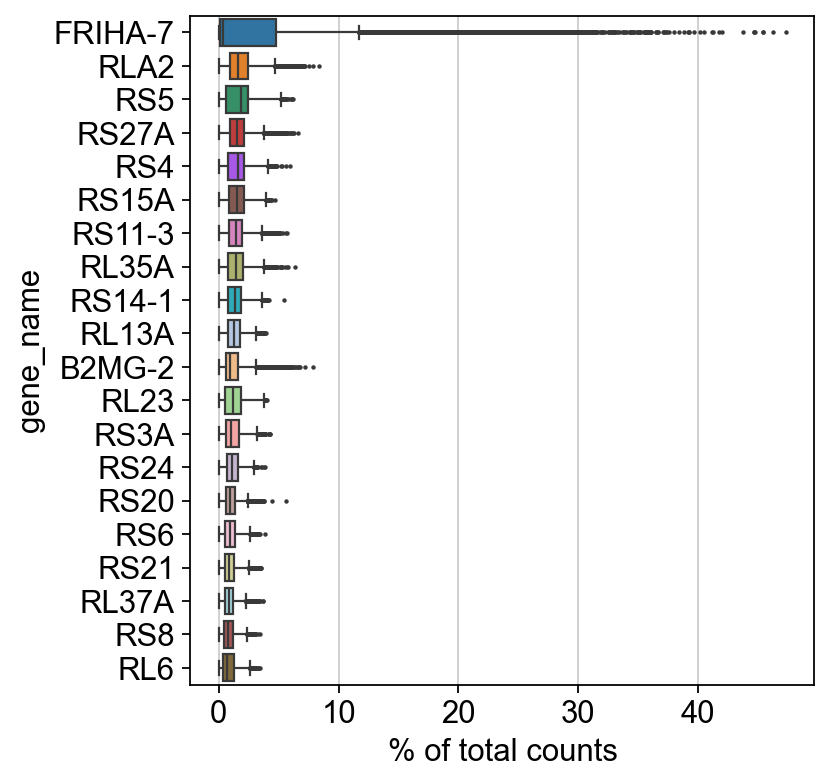

In [7]:
sc.pl.highest_expr_genes(adata, n_top=20)

In [9]:
sc.pp.filter_cells(adata, min_genes=100) 
sc.pp.filter_genes(adata, min_cells=3)
print(adata.shape) 

adata

(28863, 9023)


AnnData object with n_obs × n_vars = 28863 × 9023
    obs: 'treatment', 'n_genes'
    var: 'gene_ids', 'feature_types', 'n_cells'

In [10]:
dict_replace = {'COX1':'MT-COX1','COX2':'MT-COX2','COX3':'MT-COX3','ND1':'MT-ND1-1','ND1':'MT-ND1-2','ND2':'MT-ND2',
                'ND3':'MT-ND3','ND4':'MT-ND4','ND5':'MT-ND5','ND6':'MT-ND6','ND4L-1':'MT-ND4L','ATP6':'MT-ATP6','ATP8':'MT-ATP8',
                'CYTB':'MT-CYTB'}
adata.var.rename(dict_replace, inplace=True)
# ONLY MT-ATP6, MT-ND1, MT-ND4L

In [11]:
adata.var['MT'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'MT'
sc.pp.calculate_qc_metrics(adata, qc_vars=['MT'], percent_top=None, log1p=False, inplace=True)

In [12]:
sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=False, inplace=True)

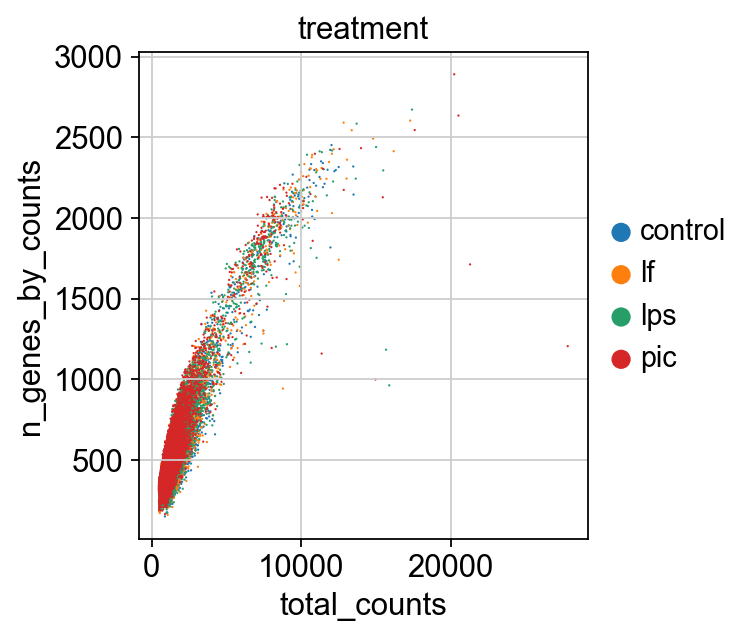

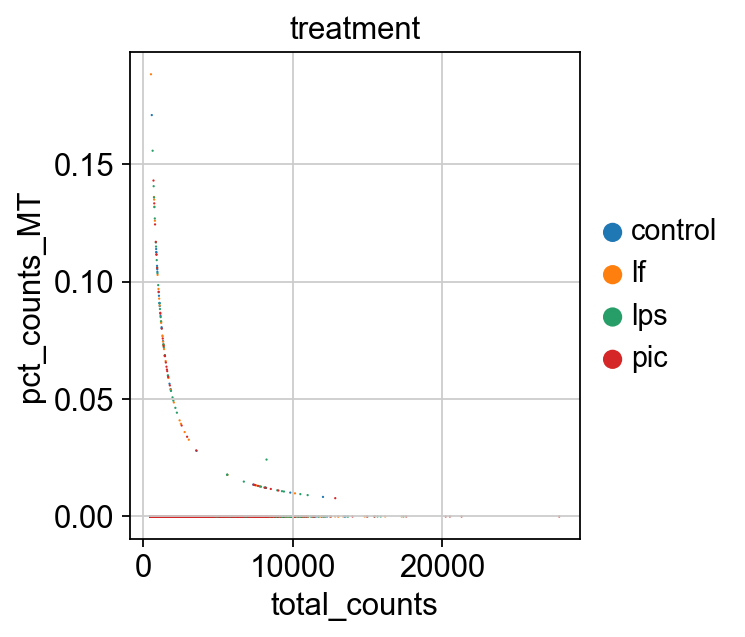

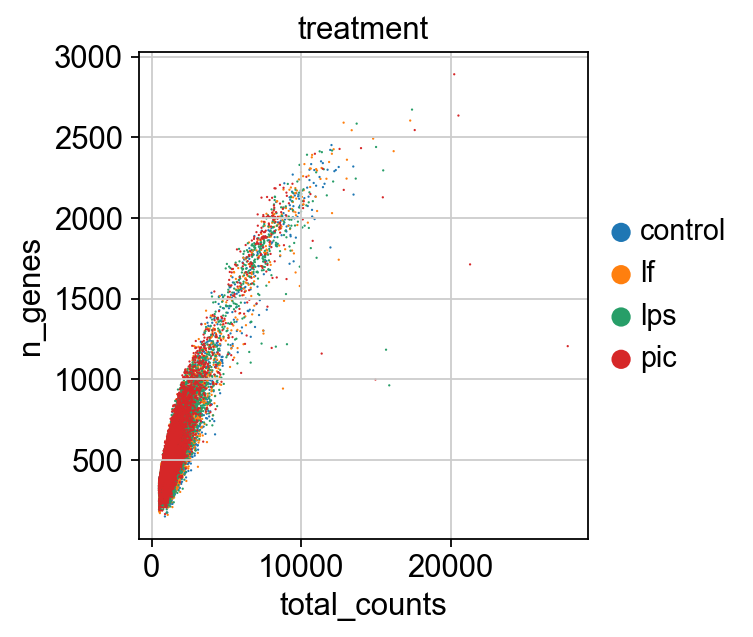

In [13]:
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts', color='treatment')
sc.pl.scatter(adata, x='total_counts', y='pct_counts_MT', color='treatment')
sc.pl.scatter(adata, x='total_counts', y='n_genes', color='treatment', save=True)

In [14]:
adata = adata[adata.obs.pct_counts_MT < 20] 
adata = adata[adata.obs.total_counts < 5000, :] # If filtering outliers (<0.1% of cells)

adata

View of AnnData object with n_obs × n_vars = 28049 × 9023
    obs: 'treatment', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_MT', 'pct_counts_MT'
    var: 'gene_ids', 'feature_types', 'n_cells', 'MT', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'treatment_colors'

In [15]:
import scrublet as scr

In [16]:
def scrub(adatas, adata, adata_names):
    print('Before scrublet: ', adata.shape[0])
    doub_index = []
    barcodes = []
    for data, name in zip(adatas, adata_names):
        data.raw = data
        sc.pp.normalize_total(data, target_sum=1e4)
        sc.pp.log1p(data)
        scrub = scr.Scrublet(data.raw.X)
        data.obs['doublet_scores'], data.obs['predicted_doublets'] = scrub.scrub_doublets()
        scrub.plot_histogram()
        print('Doublets' + name + ' :', data.obs[data.obs['doublet_scores'] > 0.25].shape[0])
        barcodes = data.obs[data.obs['doublet_scores'] < 0.25].index.to_list()
        for barcode in barcodes:
            doub_index.append(barcode + '-' + name)
            
    adata = adata[adata.obs.index.isin(doub_index)]
    print('After scrublet: ', adata.shape[0])
    return adata

Before scrublet:  28049
normalizing counts per cell
    finished (0:00:00)
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.31
Detected doublet rate = 3.9%
Estimated detectable doublet fraction = 61.9%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 6.4%
Elapsed time: 9.8 seconds
Doubletscontrol : 288
normalizing counts per cell
    finished (0:00:00)
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.29
Detected doublet rate = 5.3%
Estimated detectable doublet fraction = 59.0%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 9.0%
Elapsed time: 8.7 seconds
Doubletslf : 420
normalizing counts per cell
    finished (0:00:00)
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at d

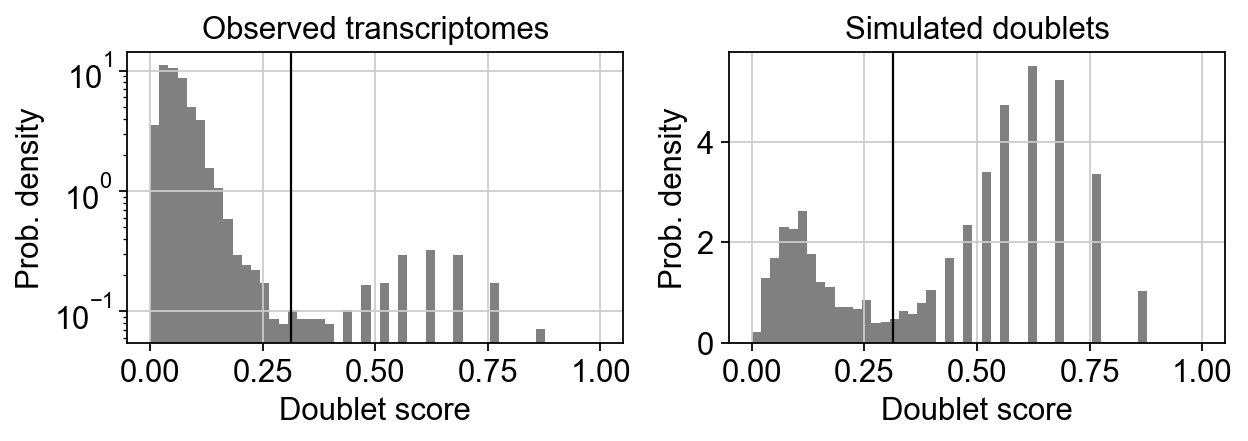

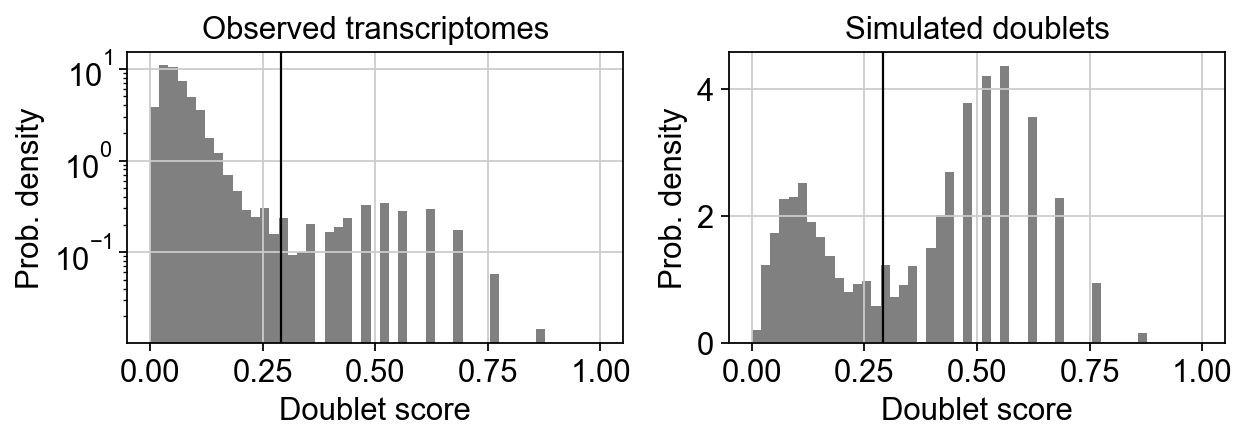

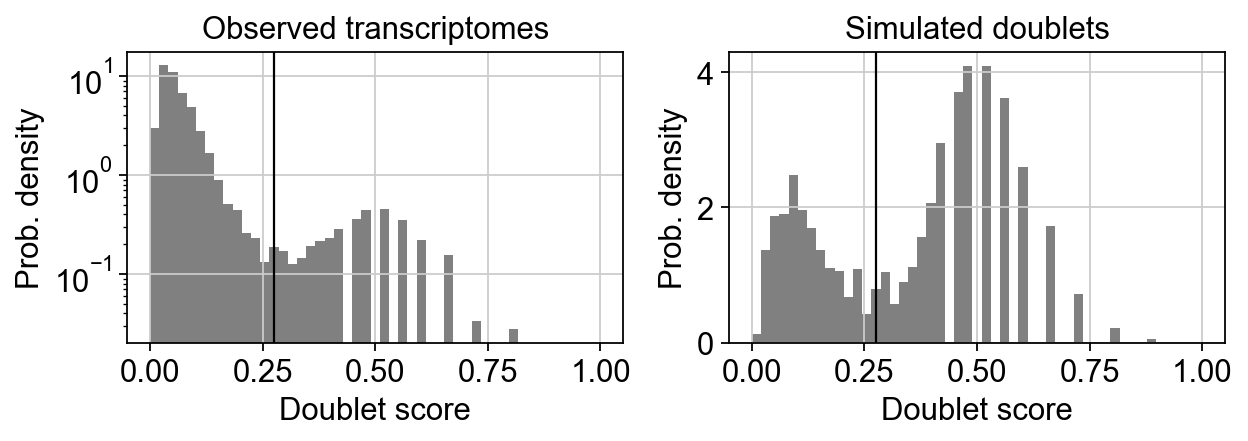

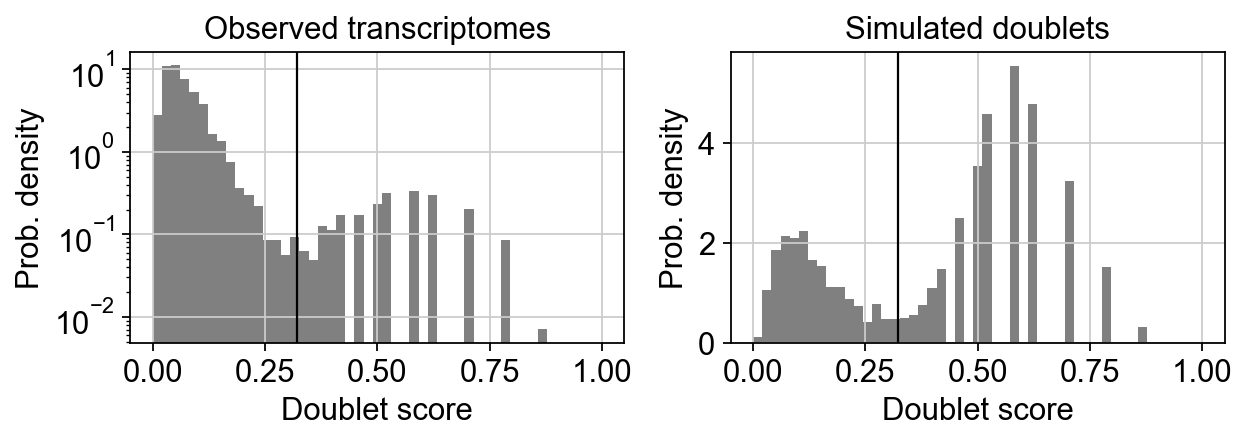

In [17]:
adata = scrub(adatas, adata, data_names)

### Cell cycle scoring

In [18]:
cell_cycle_genes = [x.strip() for x in open(r'/Code/data/single_cell/animals/regev_lab_cell_cycle_genes.txt')]

s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]
cell_cycle_genes = [x for x in cell_cycle_genes if x in adata.var_names]
s_genes = [x for x in s_genes if x in adata.var_names]
g2m_genes = [x for x in g2m_genes if x in adata.var_names]

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score of gene set (adata.obs).
    130 total control genes are used. (0:00:01)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs).
    156 total control genes are used. (0:00:01)
-->     'phase', cell cycle phase (adata.obs)
computing PCA
    with n_comps=27
    finished (0:00:00)
    and added
    'X_pca', the PCA coordinates (adata.obs)
    'PC1', 'PC2', ..., the loadings (adata.var)
    'pca_variance', the variance / eigenvalues (adata.uns)
    'pca_variance_ratio', the variance ratio (adata.uns)


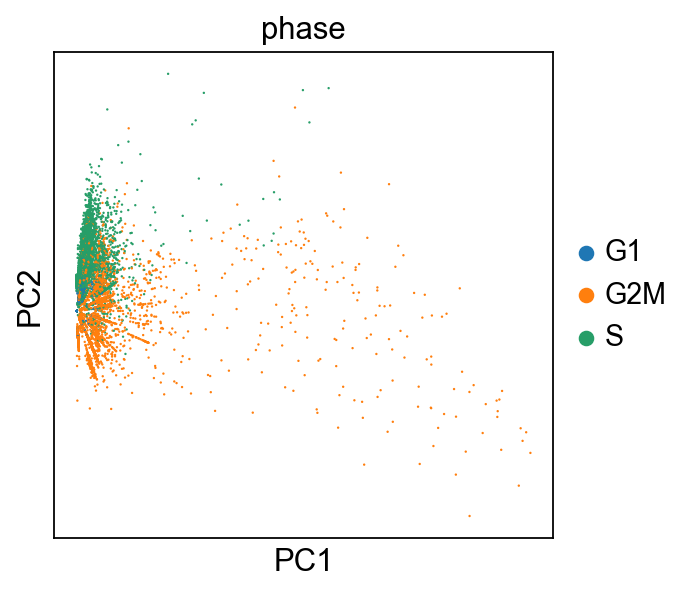

C:\Users\TzachiHNB2\AppData\Local\Temp\ipykernel_53200\1917813240.py:10: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['S_score'] = cell_cycle_adata.obs['S_score'].copy()


In [19]:
cell_cycle_adata = adata.copy()

sc.pp.normalize_per_cell(cell_cycle_adata, counts_per_cell_after=1e4)
sc.pp.log1p(cell_cycle_adata)
sc.pp.scale(cell_cycle_adata)
sc.tl.score_genes_cell_cycle(cell_cycle_adata, s_genes=s_genes, g2m_genes=g2m_genes)
adata_cc_genes = cell_cycle_adata[:, cell_cycle_genes].copy()
sc.tl.pca(adata_cc_genes)
sc.pl.pca_scatter(adata_cc_genes, color='phase', save=True)
adata.obs['S_score'] = cell_cycle_adata.obs['S_score'].copy()
adata.obs['G2M_score'] = cell_cycle_adata.obs['G2M_score'].copy()
adata.obs['phase'] = cell_cycle_adata.obs['phase'].copy()

## Saving adata

In [20]:
adata.write(r'/Code/data/single_cell/animals/crocodile/crocodile_3/''crocodile_3_after_qc.h5ad')

In [ ]:
# Preparing files to be opened in R studio

matrix_dense = adata.X.toarray()

# Create a DataFrame from the dense array with observation names as index and variable names as columns
matrix_df = pd.DataFrame(matrix_dense, index=adata.obs_names, columns=adata.var_names)

# Save the DataFrame to a CSV file
matrix_df.to_csv(r'/Code/data/single_cell/animals/turtle/turtle_3/''matrix_new.csv')
print('matrix file is transformed')

#save obs as scv
adata.obs.to_csv(r'/Code/data/single_cell/animals/turtle/turtle_3/''obs_new.csv')
print('obs file is transformed')

# Save variable data to a CSV file
adata.var.to_csv(r'/Code/data/single_cell/animals/turtle/turtle_3/''var_new.csv')
print('var file is transformed')